In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


# Incertidumbre

Una ventaja de usar modelos probabilisticos es que nos permiten contemplar cierta incertidumbre en el proceso de los modelos.

Hay dos tipos de incertidumbre con la que tenemos que trabajar $\textbf{Aleatoria}$ y $\textbf{epistemica}$.

La $\textbf{ Incertidumbre Aleatoria}$ : es referente a los datos mismos, producidos por ejemplo  por errores de medicion, o ruido en las etiquetas del set de datos, esta incertidumbre es irreducible siempre va a existir, siempre hay que tenerla en cuenta. 

La  $\textbf{ Incertidumbre Aleatoria}$ se divide en dos tipos $\textbf{ Heterocedastica(Heteoscedastic)}$ y $\textbf{ Homocedastica(Homosceastic)}$ :

La diferencia es si el ruido depende de la variable de entrada o no, si la incerdumbre de los datos es la misma para todas las variables objetivo entonces es  $\textbf{ Homocedastica)}$, si la incertidumbre de los datos varia de acuerdo a la variable de entrada entonces es $\textbf{ Heterocedastica}$


La $\textbf{Incertidumbre Epistemica}$: Esta relacionada al modelo por decir si tenemos pocos datos la distribucion que modelara sera probe en ciertos patrones y esto genera cierta incertidumbre en el modelo.

Desarrollaremos modelos que contemplen ambos tipos de incertidumbre.


# Probabilistic layers and Bayesian neural networks

Ya que vimos los objetos de distribucion tenemos que sabe como agregarlos a nuestros modelos, para esta finalidad existen las capas probabilisticas dentro de TensorFlow probability

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [ ]:
#supongamos que tenemos datos que se comportan de una forma lineal  con un poco de ruido
#y=<x,w>+b + ruido
#supongamos que el ruido esta generado por una distribucion normal
#ruido ~ N(0,σ²)

#Note que definir una regresion lineal para este modelo con funcion de perdida mse (error cuadraico medio ) 
#es quivalente  a maximizar la funcion de similitud de densidad (likelihood) haciendo algunas 
#suposiciones estadisticas:

# θ=(w,b)
# θ* es la  θ que maximiza P(D|θ)

#ahora podemos incluir la distribucion normal:

#importamos tensorlow
import tensorflow as tf
#tomamos modulo secuencial para construir modelo
from tensorflow.keras.models import Sequential
#tomamos la capa densa
from tensorflow.keras.layers import Dense
#importamos tf probabilistico
import tensorflow_probability as tfp

#bautizamos referencia a distribuciones
tfd=tfp.distributions

#bautizamos al modulo de capas probabilisticas dentro de tensorflow_probability
tfpl=tfp.layers

#constuimos modelo secuencial como siempre
modelop=Sequential([
    #definimos capa densa la salia de esta capa definira la media de la distribucion normal de la 
    #siguiente capa
    Dense(1,input_shape=(2,)),
    #definimos capa lambda de distribucion que recibe una funcion lambda que sera un objeto de ditribucion
    #note que la desviacion permanece constante en 1, la capa recibe la salida de la capa densa
    #la pasa por una funcion lambda y devuelve un objeto de distribucion(t=tensor salida de la capa densa)
    #este tensor depende internamente de las variables de tf  de la capa densa por ende la distribucion 
    #es entrenable
    tfpl.DistribuionLambda(
        lambda t: tfd.Normal(loc=t,scale=1)
    )
])

#ahora el modelo regresa un objeto distribucion por ejemplo si x_samble es tensor de forma (16,2)
modelp(x_sample) #regresara un objeto distribucion con batch_shape=[16,1] 

#si definimos nuestra funcion nnl (negative log likelihood) que queremos maximizar (pues es negativa)
#tendremos algo como:

def nll(y_true,y_pred): #donde y_pred es la distribucion resultante del modelo 
    return -y_pred.log_prob(y_true)

#podemos compilar nuestro modelo pasando nuestra funcion de perdida como cuando le pasamos cualquier
#funcion de perdida definida por nosotros:
modelp.compile(loss=nll,optimizer='rmsprop')

#entrenamos como siempre y tenemos modelo probabilistico:
model.fit(x_train,y_train,epochs=10)

#como regresa un objeto distribucion podemos ocupar los metodos de distribucion conocidos sobre el modelo

#para obtener predicciones hacemos un muestreo
modelo(x_test).sample()

#podemos obtener la media 
modelo(x_test).mean()


In [ ]:
#recordemos que esta capa regres un onjeto de distribucion 
tfpl.DistribuionLambda(
        lambda t: tfd.Normal(loc=t,scale=1)
    )
#que sucede si no es la capa final del modelo, mas bien una intermedia, tenemos que pasar 
#su salida a otra capa pero las capas no reciben objetos distribuciones si no tensores 
#por ello existe uns forma de obener tensores de distribucion  pasando a la capa un segundo parametro
#convert_to_tensor_fn el cual puede tomar distintas cosas de la distribucion y devlverla como tensor por ejemplo
#convert_to_tensor_fn=tf.Distribution.sample pasa muestreo a tensor
#convert_to_tensor_fn=tf.Distribution.mean pasa media a tensor
#convert_to_tensor_fn=tf.Distribution.mode pasa moda a tensor

tfpl.DistribuionLambda(
        lambda t: tfd.Normal(loc=t,scale=1),
        convert_to_tensor_fn=tf.Distribution.sample
    )

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

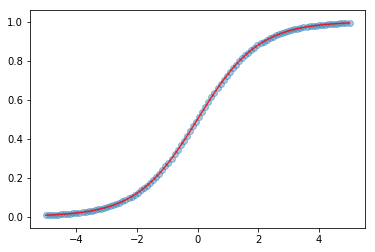

In [5]:
# Create a sigmoid model, first deterministic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
#grafica puntos predichos por el modelo
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
#grafica la sigmoide
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

#note como las predicciones del modelo (azules) coinciden con la sigmoide pues son generados por esa funcion de
#actiacion

In [6]:
# Create a constant input for this model
x=np.array([[0]])
x

array([[0]])

In [7]:
# Explore the feedforward object...
y_predict=model(x)
y_predict

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [8]:
# ... and its behaviour under repeated calls
#cada vez que se ejecuta da el mismo valor pues es deterministico
for _ in range(5):
    print(model.predict(x))

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


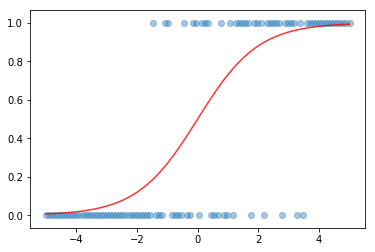

In [10]:
#generando el mismo modelo pero probabilistico
model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    #pedimos salida como un tensor muestreo para graficar
    tfpl.DistributionLambda(lambda t : tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
#grafica puntos predichos por el modelo
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
#grafica la sigmoide
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

#note qe ahora los valores se generan por la sigmoide pero las predicciones se afectan por la bernoulli 
#ahora arroja 0's y 1's

In [11]:
# Creemos enrada constante para modelo
x=np.array([[0]])
print(x)
print()

# veamos que arroja el modelo
y_predict=model(x)
print(y_predict)

[[0]]

tfp.distributions.Bernoulli("sequential_1_distribution_lambda_Bernoulli", batch_shape=[1, 1], event_shape=[], dtype=int32)


In [16]:
# ... and its behaviour under repeated calls
#note como ya no arroja simepre lo mismo pues ya es probabilistico
#si ejecutas varias veces los valors cambian 
for _ in range(5):
    print(model.predict(x))

[[1]]
[[0]]
[[0]]
[[1]]
[[1]]


#### Use the forward model to create probabilistic training data


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



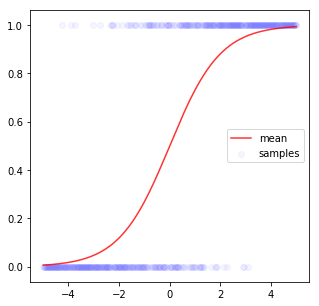

In [17]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution

#note que al graficar la media recuperamos la sigmoide

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()


#### Create a new probabilistic model with the wrong weights

In [18]:
# Create a new version of the model, with the wrong weights

#al mismo modelo cambiemos el inicializador de pesos
model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    #pedimos salida como un tensor muestreo para graficar
    tfpl.DistributionLambda(lambda t : tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

#veamos si al entrenar el modelo podemos recuperar los pesos adecuados

#### Train the new model with the negative loglikelihood

In [19]:
# Define negative loglikelihood, which we will use for training

#recuerde que y_pred es objeto de distribucion
def nll(y_true,y_pred):
    return -y_pred.log_prob(y_true)

In [20]:
# Compile untrained model
model_untrained.compile(loss=nll,optimizer=RMSprop(learning_rate=0.01))


In [21]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

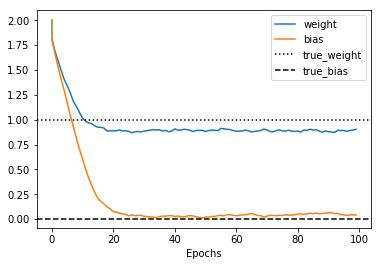

In [22]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#note como al entrenar nos acercamos a los pesos reales

In [33]:
#NOTA

x=tf.Variable([[1,2],[3,4],[5,6],[7,8]])
print(x)
print()

y=x[...,:1]
print(y)
print()

z=x[...,1:]
print(z)

<tf.Variable 'Variable:0' shape=(4, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]], dtype=int32)>

tf.Tensor(
[[1]
 [3]
 [5]
 [7]], shape=(4, 1), dtype=int32)

tf.Tensor(
[[2]
 [4]
 [6]
 [8]], shape=(4, 1), dtype=int32)


***
<a id="coding_tutorial_2"></a>
## Probabilistic layers


In [ ]:
#capa de normal indepeniente IndependentNormal es una capa probabilistica toma la salida de la capa densa anterior
#y parametriza una distribucion normal, el parametro de la capa es el event_shape así como la normal necesita 2 
#parametros media y varianza si IndependentNormal(n) debe recibir 2^n valores (vea ejemplo2) 
model=Sequential([
    Dense(16,activation='relu',input_shape=(2,)),
    Dense(2), #esta arroja cosas de forma (lote,2)
    
    #genera lote de normales univaluadas
    tfpl.IndependentNormal(1)
])

#si x_sample es de forma (16,2) tenemos que 
model(x_sample) #arroja objeto distribucion con batch_shape[16] even_shape=[1] ie un lote de 16 normales univaluadas

#ejemplo2
model=Sequential([
    Dense(16,activation='relu',input_shape=(2,)),
    
    Dense(4), #esta arroja cosas de forma (lote,4)
    #arroja 4 2 valores para media y 2 valores para desviacion estandar
    
    #toma 4 valores y genera normal multivaluada de 2 dimensionescon matriz de covarianza diagonal
    tfpl.IndependentNormal(2)
])


#ejemplo3
model=Sequential([
    Dense(16,activation='relu',input_shape=(2,)),
    
    Dense(8), #esta arroja cosas de forma (lote,8)
    #arroja 8 2 valores para media y 2 valores para desviacion estandar del primer lote y
    #2 valores para media y 2 valores para desviacion estandar del segundo lote
    
    
    #toma 8 valores y genera lote de 2 normal multivaluada de 2 dimensionescon matriz de covarianza diagonal
    tfpl.IndependentNormal([2,2])
])

si x_sample es de forma (16,2) tenemos que 
model(x_sample) #arroja objeto distribucion 
#con batch_shape[16] even_shape=[2,2] ie un lote de 16 normales de dos variables

#note que en los ejemplos anteriores debemos asegurarnos de que la capa densa que antecede a 
#tfpl.IndependentNormal mande la cantidad correcta de parametros, afortunadamente la capa tiene metodo llamado
# .params_size que toma como argumento el event_shape y regresa el numero de parametros necesarios para 
# la capa , así podemos dejarnos de preocupar por la unidades de la capa densa previa mediamnte:
#solo tenemos que hacer event_shape = la forma deseada para este mismo
model=Sequential([
    Dense(16,activation='relu',input_shape=(2,)),
    #auromaticamente le dice a la capa densa cuantas unidades requiere para la forma dada
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    #tambien podemos pedir su salida como tensor con el uso de convert_to_tensor_fn
    tfpl.IndependentNormal(event_shape,convert_to_tensor_fn=tfd.Distribution.sample)
])

#por ejemplo
IndependentNormal.params_size(1)#devuelve 2
IndependentNormal.params_size(2)#devuelve 4
.
.
.
IndependentNormal.params_size(n)#devuelve 2^n

IndependentNormal.params_size([2,2])#devuelve 8

#todas las capas probabilisticas tienen el metodo .params_size 


#existe capa probabilistica One Hot Categorical 
model=Sequential([
    #mas capas de red convolucional
    Dense(tfpl.OneHotCategorical.params_size(num_clases)),
    tfpl.OneHotCategorical(num_clases) #esta capa regresa objeto de distribucion one hot categorica 
    #si hacemos un muestreo regresa vectores de long num_clases donde cada valor es 0 o 1
])


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

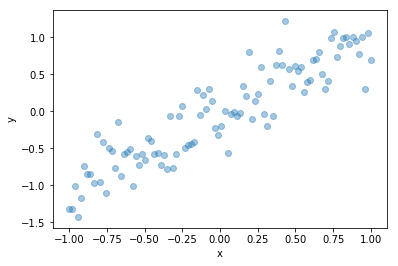

In [3]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


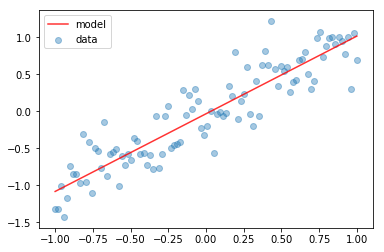

In [8]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [9]:
# Examine the model predictions
x=np.array([[0]])
y_model=model(x)
y_model


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03338744]], dtype=float32)>

#### Probabilistic linear regression with both user-defined and learned variance

In [10]:
# Create probabilistic regression with normal distribution as final layer

#en el modelo dejamos fija la desviacion lo que le da menos flexibilidad 
model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t : tfd.Independent(tfd.Normal(loc=t,scale=1)) )
])

In [13]:
# Train model using the negative loglikelihood
#recuerda que y_pred es un objeto distribucion
def nll(y_true,y_pred):
    return  -y_pred.log_prob(y_true)
model.compile(loss=nll,optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train,y_train,epochs=100,verbose=2)

Train on 100 samples
Epoch 1/100
100/100 - 0s - loss: 0.9930
Epoch 2/100
100/100 - 0s - loss: 0.9873
Epoch 3/100
100/100 - 0s - loss: 0.9835
Epoch 4/100
100/100 - 0s - loss: 0.9804
Epoch 5/100
100/100 - 0s - loss: 0.9775
Epoch 6/100
100/100 - 0s - loss: 0.9752
Epoch 7/100
100/100 - 0s - loss: 0.9729
Epoch 8/100
100/100 - 0s - loss: 0.9715
Epoch 9/100
100/100 - 0s - loss: 0.9700
Epoch 10/100
100/100 - 0s - loss: 0.9683
Epoch 11/100
100/100 - 0s - loss: 0.9672
Epoch 12/100
100/100 - 0s - loss: 0.9658
Epoch 13/100
100/100 - 0s - loss: 0.9649
Epoch 14/100
100/100 - 0s - loss: 0.9636
Epoch 15/100
100/100 - 0s - loss: 0.9624
Epoch 16/100
100/100 - 0s - loss: 0.9612
Epoch 17/100
100/100 - 0s - loss: 0.9607
Epoch 18/100
100/100 - 0s - loss: 0.9602
Epoch 19/100
100/100 - 0s - loss: 0.9595
Epoch 20/100
100/100 - 0s - loss: 0.9588
Epoch 21/100
100/100 - 0s - loss: 0.9584
Epoch 22/100
100/100 - 0s - loss: 0.9576
Epoch 23/100
100/100 - 0s - loss: 0.9576
Epoch 24/100
100/100 - 0s - loss: 0.9572
Epoc

In [14]:
# Examine the distribution created as a feedforward value
#retorna objeto distribucion
x=np.array([[0]])
y_model=model(x)
y_model

<tfp.distributions.Independent 'sequential_1_distribution_lambda_Independentsequential_1_distribution_lambda_Normal' batch_shape=[1] event_shape=[1] dtype=float32>


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



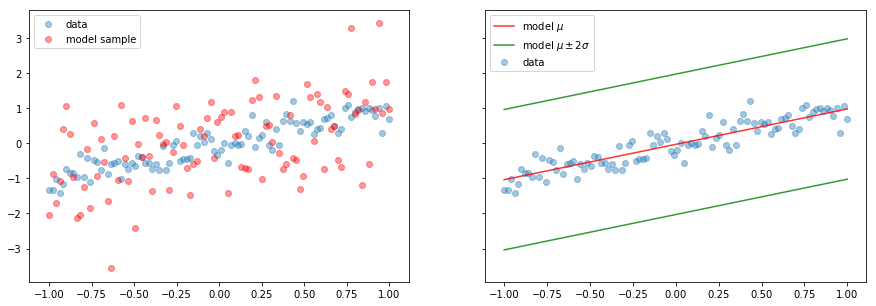

In [15]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#arroja dos graficas una donde grafica los datos de entrenamiento y una muestra de la distribucion resultante
#del entrenamiento con los mismos valores x que los datos originales

#y otra de los datos del modelo como la media y a desviacion 

In [16]:
#entrenemos ambos parametros de la distribucion 

model = Sequential([
    Dense(units=2, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t : tfd.Independent(tfd.Normal(
        #separamos por vectores [x,y] en [x],[y] y los pasamos uno a cada parametro
        #note que para la desviacion estandar pasamos los parametros por softplus pues
        #la desviacion no puede ser negativa y  softplus:IR->IR⁺
        loc=t[...,:1],scale=tf.math.softplus(t[...,1:]))) )
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [19]:
#podemos hacer un modeloequivalente con menos codigo y mas leible usando IndependentNormal:
#y usando params_size para inferir unidades de la forma del espacio de eventos even_shape
#note en el sumary que el modelo es el mismo 

event_shape=1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 4         
_________________________________________________________________
independent_normal (Independ ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [20]:
#compilemos y entrenemos modelo con ambas variables entrenables
model.compile(loss=nll,optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train,y_train,epochs=200,verbose=0)

In [21]:
x=np.array([[0]])
y_model=model(x)
y_model

<tfp.distributions.Independent 'sequential_3_independent_normal_IndependentNormal_Independentsequential_3_independent_normal_IndependentNormal_Normal' batch_shape=[1] event_shape=[1] dtype=float32>


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



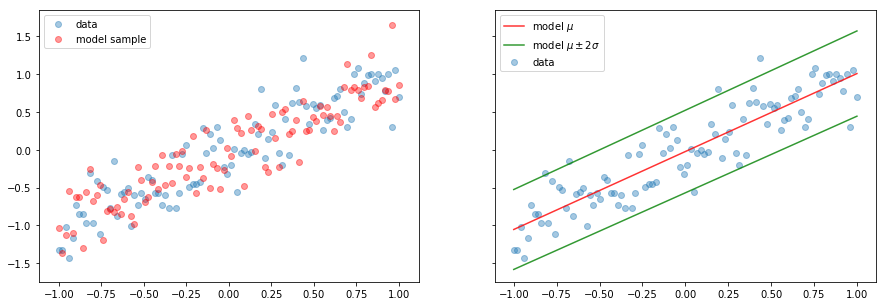

In [22]:
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#arroja dos graficas una donde grafica los datos de entrenamiento y una muestra de la distribucion resultante
#del entrenamiento con los mismos valores x que los datos originales

#y otra de los datos del modelo como la media y a desviacion note como ahora se adapta mejor

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

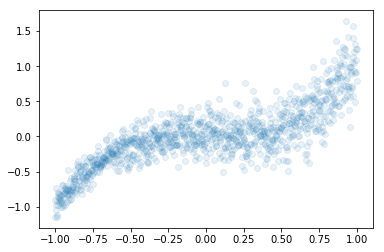

In [23]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [24]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 18        
_________________________________________________________________
independent_normal_1 (Indepe ((None, 1), (None, 1))    0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 262us/sample - loss: -0.1219


-0.12185406470298767


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



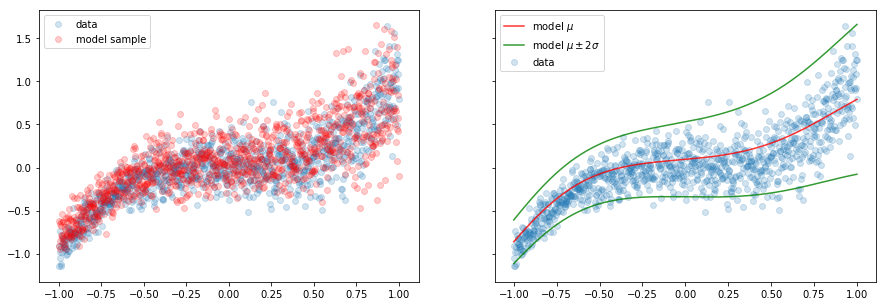

In [26]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

Hasta ahora hemos dotado a los modelos a traves de las capas probabilisticas de manejar la incertidumbre referente a los datos (incertidumbre aleatoria), logrando que los modeos aprendan una media o varianza adecuada a aprtir de los datos y arrojando una distribucion de probabilidad,podemos pensar en las capas probabilisticas como funciones de activacion estocasticas para nuestros modelos, hasta ahora solo las hemos ocupado en la capa de salida para producir un objeto de distribucion y que la salida de nuestro modelo sea una variable aleatoria, esto bajo la premisa de saber que nuestros datos y etiquetan tienen ruido proveniente de alguna distribución.

Ahora lidiemos con la incertidumbre epistemológica referente al modelo que tan bien las variables anstraen los datos, hasta ahora los modelos clasicos de M.L al ser entrenados tienen un solo valor para cada peso en el modelo,
pero puede haber muchos valores distintos para los parametros que hacen un buen trabajo al modelar las relaciones entre los datos de entrada y salida.

## Modelo Bayesiano

Por decir podemos tener valores de los pesos que modelen bien los datos, pero si recolectamos mas datos tenemos mas info y los pesos pueden cambiar para abstraer nueva informacion, Así que dado un set de datos tenemos un conjunto de valores para los pesos del modelo , esto representa una distribiución sobre los posibles valores de los pesos.
Conocida como $\textbf{Distribucion posterior (Posterior Distribution)}$

La distribucion posterior captura la idea de los mejores pesos dado un set de datos, cuando empezamos con el presoceso iniciamos con una $\textbf{Distribucion priori (Priori Distribution)}$ es la idea de cuales son los mejores pesos sin haber visto ningun set de datos y despues de ver el primer set de datos se calcula la distribucion posterior y asi iterativamente.
Este proceso el modelado Bayesiano.

En practica aprender la distribucion posterior es muy dificil y por ende debemos aproximarla 

In [ ]:
#entonces para tratar de aprende la distribucion posterior  necesitamos comenzar con una distribucion priori
#un estandar es escoge la gaussiana esferica ie una distribucion normal independiente para cada peso y sesgo todas
#equivariantes

#probabilidad prior para una capa densa:

#recibe el tamaño de los pesos(numero de parametros en la matriz de pesos) W y 
#tamaño de sesgo (numero de parametros en el vector de sesgos) b
def prior(kernel_size,bias_size,dtype=None):
    
    n=kernel_size+bias_size#total de parametros
    
    #regresa una funcion lambda que toma un vector de entrada y regresa una distribucion normal independiente
    #con media 0 y varianza 1 , esta distribucion es la prior sobre los parametros de la capa densa 
    #Note que el tensor t no se usa para nada en la distribucion y la distribucion no tiene variables entrenables
    #
    return lambda t : tfd.Independent(tfd.Normal(loc=tf.zeros(n,dtype=dtype),scale=1),
                                      reinterpreted_batch_ndims=1)

#definamos la distribucion posterior que calcula los pesos dado un set de datos:

#recibe el tamaño de los pesos(numero de parametros en la matriz de pesos) W y 
#tamaño de sesgo (numero de parametros en el vector de sesgos) b
def posterior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size#total de parametros
    
    #regresa un modelo secuencial que toma un tensor como entrada y regresa un objeto de distribucion
    return Sequential([
        
        #definimos una capa VariableLayer que retorna una variable de tensorflow 
        #respecto a la entrada que se le de, note que la distribucion posteriror tambien es independiente 
        #al tensor de salida de la capa densa al igual que la prior
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),dtype=dtype),
        #esta normal independiente tiene un even_size=n por ende la distribucion posterior regresa una distribucion
        #normal sobre los parametros de la capa densa
        #note que lo regresamos como tensor de muestreo pues tenemos que psarlo a otra capa
        # esta trasformacion la indicamos con convert_to_tensor_fn=tfd.Distribution.sample
        tfpl.IndependentNormal(n,convert_to_tensor_fn=tfd.Distribution.sample)
    ])

#Capa DenseVarational

#ya podemos definir un modelo de deep learning ocupando modelo bayesiano usando distribuciones para los
#pesos del modelo en vez de estimadores puntuales, simplemente reemplazando las capas densas del modelo por 
#DenseVarational que es similar a una densa convencional pero acepta como parametros las funciones que definen la 
#distribucion prior y posterior, esta capa agrega la perdida de divergencia KL (KL divergence loss) en la
#optimizacion del modelo que es una reguarizacion para los pesos la cual podemos escalar mediante el parametro 
#kl_weight en este caso 1/N donde N es el tamaño del set de datos

model=Sequential([
    tfpl.DenseVariational(16,posterior,prior,kl_weight=1/N,activation='relu',input_shape=(8,),kl_use_exact=True),
    tfpl.DenseVariational(2,posterior,prior,kl_weight=1/N,kl_use_exact=True),
    tfpl.IndependentNormal(1)
])

#kl_use_exact=True determina como se calcula KL, dependiendo en la eleccion de distribuciones 
#usadas para la posterior y prior puede ser calculada analiticamente.
#Si la solucion analitica esta registrada en la libreria tensorflow_probability entonces pasamos True , si no esta 
#registrada arrojara un error, si lo ponemos en False que es el default se estima usando el tensor de Pesos dado 
#por la distribucion posterior 

Queremos maximizar $\textbf{ELBO (evidence lowe bound)}:$

Si denotamos la distribucion posterior por q y p la prior tenemos  

$$q=q(W|\theta)$$ 

Donde:

$W$ es el vector que contiene todos los pesos incluidos sesgos que ahora son variables aleatorias.

$\theta$ es el vector de parametros que parametriza a la posterior (medias $\mu$ y varianzas $\sigma$ de la distribucin normal por ejemplo).

Así $\textbf{ELBO}$ esta dada por dos terminos:

1.-El esperado de la negativeloglikelihood de los datos donde el esperado se toma sobre los pesos posteriores  y 

2.-El la divergencia KL entre la posterior y la priori lo que se puede pensar como una regularizacion de la posterior :

$$E_{w~q}[\log (P(D|w))]-KL[q||p]$$

Suponiendo que los datos son $\textbf{IID identicamente distribuidos e independientes}$ tenemos que

$$E_{w~q}[\log( P(D|w))]= \sum\limits_{i=1}^N E_{w~q}[log( P(D_i|w))]$$ 

Que es la suma de la negativeloglikelihood sobre todos lso datos

Asi tenemos: 

$$E_{w~q}[log( P(D|w))]-KL[q||p]=\sum\limits_{i=1}^N E_{w~q}[log( P(D_i|w))]-KL[q||p]$$

Notemos que la sima depende de los datos pero la divergencia KL no, esta depende solo de las distribuciones posterior y prior sobre los pesos.

Cuando entrenamos un modelo optimizamos ELBO usando mini lotes es decir calculamos una suma parcial del total de datos por lo que debemos escalar la suma por un factor $\displaystyle \frac{N}{B}$ donde $N$ es el total de elementos en el set de datos y $B$ el total de datos en el mini lote, de esta forma la suma es uan estimacion sin sesgo de la suma total KL no necesita ajuste pues solo depende de p y q no de los datos y dividiendo todo entre N tenemos que en minilotes:

$$E_{w~q}[log( P(D|w))]-KL[q||p]=\frac{1}{B}\sum\limits_{i=1}^N E_{w~q}[log( P(D_i|w))]-\overbrace{\frac{1}{N}}^{\text{kl_weight en la def del modelo}}KL[q||p]$$




In [ ]:
#ya podemos compilar y entrenar modelo

#recuede que y_pred es distribucion y note que loss para entrenar es solo nll (primera parte de ELBO) con signo -
#cada capa DenseVarationall agrega automaticamente la parte de -1/N*KL
model.compile(loss=lambda y_true,y_pred:-y_pred.log_prob(y_true))
model.fit(x_train,y_train,epochs=200)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

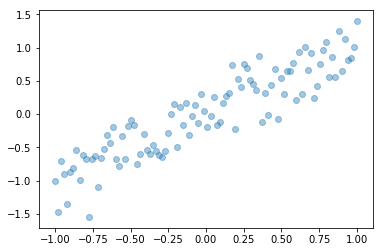

In [28]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [29]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size,bias_size,dtype=None):
    
    n=kernel_size+bias_size
    
    #en vez de funcion lamda hacemos un modelo secuencial con capa  DistributionLambda
    prior_model=Sequential([
        tfpl.DistributionLambda(
            lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),scale_diag=tf.ones(n))
        )
    ])
    
    return prior_model

In [34]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    
    posterior_model=Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

#como multivariate Gaussian no es diagonal tiene covarianza completa así MultivariateNormalTriL que es triangular
#inferior

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$ 
\mathbf{\mu}
= 
\mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [39]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model=Sequential([
    tfpl.DenseVariational(input_shape=(1,),units=1,make_posterior_fn=posterior,make_prior_fn=prior,
                          kl_weight=1/x_train.shape[0],kl_use_exact=True)
])

model.compile(loss=MeanSquaredError(),optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_4 (DenseVa (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


#### Train model and inspect

In [40]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [41]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [ 0.97038287 -0.00116256]
posterior covariance:  [0.01830797 0.00097157]
                       [0.00097157 0.00591158]


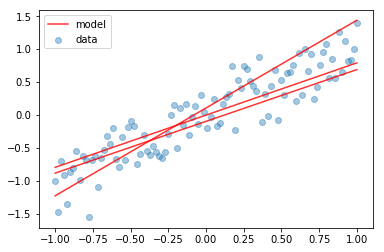

In [48]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution
#note como cada que se ejecuta las 3 lineas cambian pues sus pesos salen de una distribucion

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(3):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

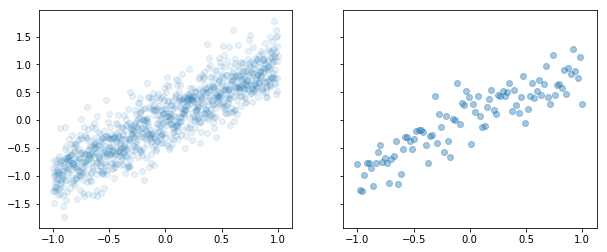

In [49]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [50]:
# Train a model on each dataset

model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

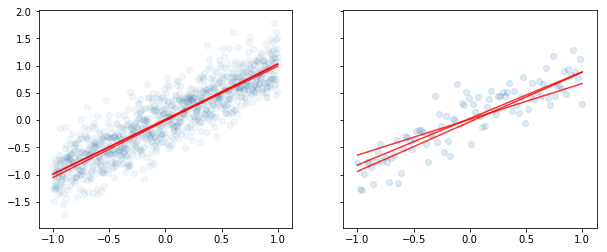

In [53]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(3):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

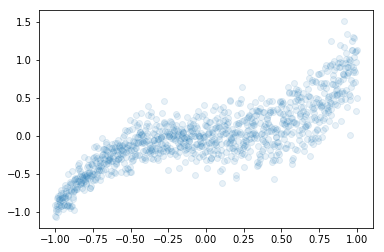

In [61]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [62]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_9 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_10 (DenseV (None, 2)                 189       
_________________________________________________________________
independent_normal_3 (Indepe ((None, 1), (None, 1))    0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 1s 884us/sample - loss: -0.0175


-0.017512309551239013


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



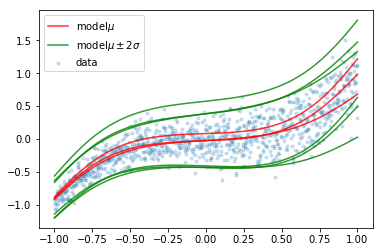

In [65]:
plt.scatter(x_train, y_train,marker='.',alpha=0.2, label='data')
for _ in range(3):
    y_model = model(x_train)
    y_hat=y_model.mean()
    y_hat_m2sd= y_hat-2*y_model.stddev()
    y_hat_p2sd= y_hat+2*y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model$\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model$\mu\pm 2\sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

DenseVariational es una actualizacion de la capa de reparametrizacion pero despues de que salio DenseVariational no habia algo parecido para redes convolucionales, por lo que para convolucionales se siguio ocupando la capa Reparametrization, esta seccion es ilustrativa pues en la actualidad existen las Capas convulocionales que sustituyeron a estas y que se detallan en otro notebook

In [90]:
#generamos modelo convolucional
from tensorflow.keras.layers import MaxPooling2D
#nota hay versiones 1D,2D y 3D
model=Sequential([
    #como capa convolucional cualquiera pasamos unidades, forma de kernel , activacion y forma
    tfpl.Convolution2DReparameterization(16,[3,3],activation='relu',input_shape=(28,28,1)),
    MaxPooling2D(3),
    Flatten(),
    #lo que arroja se usa para reparametrizar a OneHotCategorical hace lo mismo que DenseVarational
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
    
])

#detras de estas capas esta la misma teoria que detras de DenseVarational pero en estas capas hay cosas que se
#infieren automaticamente y no se notan si no las mostramos explicitamente:

model=Sequential([
    tfpl.Convolution2DReparameterization(16,[3,3],activation='relu',input_shape=(28,28,1),
                                       kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
                                       kernel_posterior_tensor_fn=tfd.Distribution.sample, 
                                       kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                       kernel_divergence_fn=(lambda q,p ,_:tfd.kl_divergence(q,p)), 
                                       bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True),
                                       bias_posterior_tensor_fn=tfd.Distribution.sample, 
                                       bias_prior_fn=None,
                                       bias_divergence_fn=None),
    MaxPooling2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
    
])

#Convolution2DReparameterization tiene opciones por separado para los paremetros del kernel y del bias
# tenemos: 
#kernel_posterior_fn=tfpl.default_mean_field_normal_fn() y
#kernel_prior_fn=tfpl.default_multivariate_normal_fn
#que son las opciones para los parametros del kernel

#default_multivariate_normal_fn() es una funcion en el modulo de capas probabilisticas que es la opcion
# por default para posteriori y se llama con sus argumentos por default retorna una
#distribucion independiente normal con media y desviacion estandar entrenables (lo mismo que se uso en
# DenseVariational)

#default_multivariate_normal_fn es una funcion en el modulo de capas probabilisticas que es la opcion
# por default para prior note que esta no se llama (no tiene parentesis) es un llamable (callable) que 
#retorna una gaussiana esferica con media 0 y desviacion estandar 1 para cada componente (lo mismo que se uso en
# DenseVariational)

#bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True) y bias_prior_fn=None
#son las opciones por default del sesgo 

#tfpl.default_mean_field_normal_fn(is_singular=True) es la misma que la anterior pero is_singular=True indica que 
#los parametros del sesgo son estimadores puntuales de nuevo y no son representados por una distribucion
#el sesgo por default se aprende de la forma usual de siempre a menos que cambiemos las opciones

#kernel_posterior_tensor_fn=tfd.Distribution.sample y bias_posterior_tensor_fn=tfd.Distribution.sample
#especifica como convertir en tensor para hacer ciertos calculos  en el caso del bias como no es
#probabilistico solo regresa el valor que tiene como tensor

#kernel_divergence_fn=(lambda q,p:tfd.kl_divergence(q,p))
#permite especificar funcion para calcular divergencia Kl por default es funcion lambda que invoca 
#a la divergencia kll de tensorflow probability en el modulo de distribuciones

#bias_divergence_fn=None permite definir funcion para calcular divergencia Kl de bias

#obviamente podemos cambias estas opciones default por otras

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

[Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

In [68]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

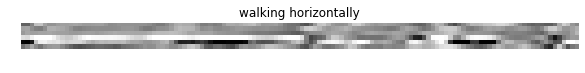

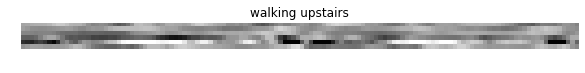

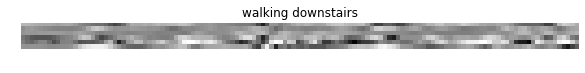

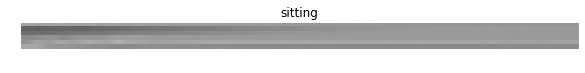

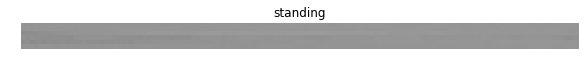

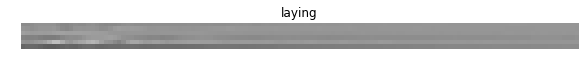

In [72]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            #aqui se transponen
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)



In [73]:
#para entender las graficas veamos la froma de un dato de entrenamiento
x_train[0].shape
#note que en la grafica se muestra al reves  pues se transpone(6,128) para que se vean a lo largo y no a lo alto ie
#6 medidas del aceleremeto por 128 tiempos
#por eso las que implican movimiento tienen mas tonos de grises y donde la persona estuvo mas quieta son 
#mas uniformes

(128, 6)

#### 1D deterministic convolutional neural network

In [70]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [94]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

#definamos funcion de divergencia
divergence_fn=(lambda q,p,_:tfd.kl_divergence(q,p)/x_train.shape[0])

model=Sequential([
    tfpl.Convolution1DReparameterization(
        input_shape=(128,6),filters=8,kernel_size=16,activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_divergence_fn=divergence_fn,
        #aqui si asignamos funcion para bias prior
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        #indicamos False para que si se interprete como distribucion
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    #note que aqui usamos version 1D
    MaxPooling1D(pool_size=16),
    Flatten(),
    #note que tambien acepta todos parametros como la convolucional
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6),activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(6)
    
])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_3  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 56)                0         
_________________________________________________________________
dense_reparameterization_8 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_8 (OneHo ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [95]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [96]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

2947/2947 [==============================] - 1s 204us/sample - loss: 0.9944 - accuracy: 0.6797


[0.994400102939693, 0.67967427]

#### Inspect model performance

In [97]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


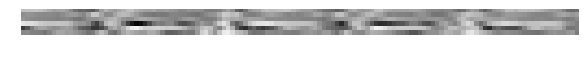

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



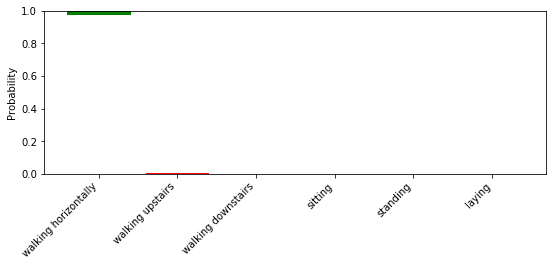

In [98]:
analyse_model_predictions(image_num=97)

------------------------------
Accelerometer data:


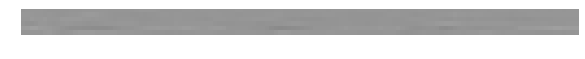

------------------------------
True activity: sitting

------------------------------
Model estimated probabilities:


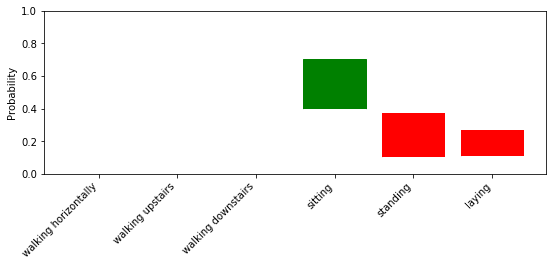

In [99]:
analyse_model_predictions(image_num=663)

------------------------------
Accelerometer data:


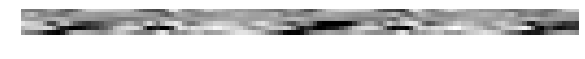

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


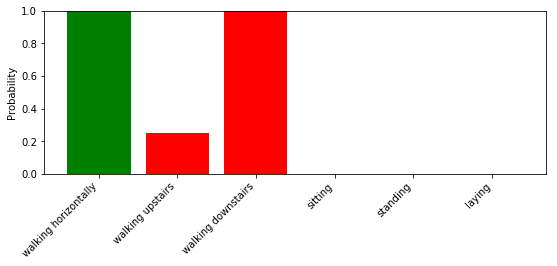

In [100]:
analyse_model_predictions(image_num=1137)